In [5]:
import numpy as np
import matplotlib.pyplot as plt

def adversarial_sequence(mu, T):
    """
    Creates an adversarial sequence of length T.
    The sequence starts with 0's and switches to 1's
    at halfway point to cause FTL to incur maximum regret.
    """
    switch_point = T // 2
    return np.concatenate((np.zeros(switch_point, dtype=int), np.ones(T - switch_point, dtype=int)))

def bernoulli_sequence(mu, T):
    return np.random.binomial(1, mu, T)

def follow_the_leader(X):
    T = len(X)
    predictions = np.zeros(T)
    for t in range(1, T):
        predictions[t] = np.argmax(np.bincount(X[:t]))
    return predictions


def hedge(X, eta_callable):
    T = len(X)
    predictions = np.zeros(T, dtype=int)
    
    # Initialize cumulative loss to 0 for each action
    L_t = np.array([0, 0])
    
    for t in range(1, T):
        eta = eta_callable(t)  # Get the learning rate for the current time step
        # Calculate probabilities for each action based on the cumulative losses
        prob = np.exp(eta * L_t) / np.sum(np.exp(eta * L_t))
        
        # Make a prediction based on the probabilities
        predictions[t] = np.random.choice([0, 1], p=prob)
        # Observe the outcome and update the cumulative loss for the action taken
        # L_t[predictions[t]] += 1 - X[t]
        L_t += (X[t] == np.array([0, 1]))

    return predictions

def compute_empirical_pseudo_regret(X, predictions, T):
    regret = np.zeros(T)
    for t in range(1, T):
        best_action = np.argmax(np.bincount(X[:t]))
        l_t = predictions[t] != best_action
        regret[t] = regret[t-1] + l_t
    return regret

def run_experiment(x_sampler, regret_func, K, T, mu_fracs, num_runs, fig_name):
    for mu_frac in mu_fracs:
        mu = 1/2 - mu_frac
        
        avg_regrets_ftl = np.zeros(T)
        avg_regrets_hedge_simple = np.zeros(T)
        avg_regrets_hedge_tight = np.zeros(T)
        avg_regrets_hedge_anytime_simple = np.zeros(T)
        avg_regrets_hedge_anytime_tight = np.zeros(T)

        regrets_ftl = []
        regrets_hedge_simple = []
        regrets_hedge_tight = []
        regrets_hedge_anytime_simple = []
        regrets_hedge_anytime_tight = []

        for _ in range(num_runs):
            X = x_sampler(mu, T)
            predictions_ftl = follow_the_leader(X)
            regrets_ftl.append(regret_func(X, predictions_ftl, T))
            # avg_regrets_ftl += regrets_ftl
            # regrets_ftl.append(regrets_ftl)
            
            eta_simple = lambda t:  np.sqrt(2 * np.log(K) / T)
            predictions_hedge_simple = hedge(X, eta_simple)
            regrets_hedge_simple.append(regret_func(X, predictions_hedge_simple, T))
            # avg_regrets_hedge_simple += regrets_hedge_simple
            # regrets_hedge_simple.append(regrets_hedge_simple)
            
            eta_tight = lambda t: np.sqrt(8 * np.log(K) / T)
            predictions_hedge_tight = hedge(X, eta_tight)
            regrets_hedge_tight.append(regret_func(X, predictions_hedge_tight, T))
            # avg_regrets_hedge_tight += regrets_hedge_tight
            # regrets_hedge_tight.append(regrets_hedge_tight)
            
            eta_simple_anytime = lambda t:  np.sqrt(2 * np.log(K) / t)
            predictions_hedge_anytime_simple = hedge(X, eta_simple_anytime)
            regrets_hedge_anytime_simple.append(regret_func(X, predictions_hedge_anytime_simple, T))
            # avg_regrets_hedge_anytime_simple += regrets_hedge_anytime_simple
            # regrets_hedge_anytime_simple.append(regrets_hedge_anytime_simple)
            
            eta_tight_anytime = lambda t: np.sqrt(8 * np.log(K) / t)
            predictions_hedge_anytime_tight = hedge(X, eta_tight_anytime)
            regrets_hedge_anytime_tight.append(regret_func(X, predictions_hedge_anytime_tight, T))
            # avg_regrets_hedge_anytime_tight += regrets_hedge_anytime_tight
            # regrets_hedge_anytime_tight.append(regrets_hedge_anytime_tight)

        avg_regrets_ftl /= num_runs
        avg_regrets_hedge_simple /= num_runs
        avg_regrets_hedge_tight /= num_runs
        avg_regrets_hedge_anytime_simple /= num_runs
        avg_regrets_hedge_anytime_tight /= num_runs
        
        mean_regrets_ftl = np.mean(regrets_ftl, axis=0)
        mean_regrets_hedge_simple = np.mean(regrets_hedge_simple, axis=0)
        mean_regrets_hedge_tight = np.mean(regrets_hedge_tight, axis=0)
        mean_regrets_hedge_anytime_simple = np.mean(regrets_hedge_anytime_simple, axis=0)
        mean_regrets_hedge_anytime_tight = np.mean(regrets_hedge_anytime_tight, axis=0)
        
        std_regrets_ftl = np.std(regrets_ftl, axis=0)
        std_regrets_hedge_simple = np.std(regrets_hedge_simple, axis=0)
        std_regrets_hedge_tight = np.std(regrets_hedge_tight, axis=0)
        std_regrets_hedge_anytime_simple = np.std(regrets_hedge_anytime_simple, axis=0)
        std_regrets_hedge_anytime_tight = np.std(regrets_hedge_anytime_tight, axis=0)

        time_steps = np.arange(T)
        plt.plot(time_steps, mean_regrets_ftl, label='FTL')
        plt.plot(time_steps, mean_regrets_hedge_simple, label='Hedge Simple')
        plt.plot(time_steps, mean_regrets_hedge_tight, label='Hedge Tight')
        plt.plot(time_steps, mean_regrets_hedge_anytime_simple, label='Hedge Anytime Simple')
        plt.plot(time_steps, mean_regrets_hedge_anytime_tight, label='Hedge Anytime Tight')
        
    
        # Fill between mean +/- one standard deviation to indicate variance
        plt.fill_between(time_steps, mean_regrets_ftl - std_regrets_ftl, mean_regrets_ftl + std_regrets_ftl, alpha=0.1)
        plt.fill_between(time_steps, mean_regrets_hedge_simple - std_regrets_hedge_simple, mean_regrets_hedge_simple + std_regrets_hedge_simple, alpha=0.1)
        plt.fill_between(time_steps, mean_regrets_hedge_tight - std_regrets_hedge_tight, mean_regrets_hedge_tight + std_regrets_hedge_tight, alpha=0.1)
        plt.fill_between(time_steps, mean_regrets_hedge_anytime_simple - std_regrets_hedge_anytime_simple, mean_regrets_hedge_anytime_simple + std_regrets_hedge_anytime_simple, alpha=0.1)
        plt.fill_between(time_steps, mean_regrets_hedge_anytime_tight - std_regrets_hedge_anytime_tight, mean_regrets_hedge_anytime_tight + std_regrets_hedge_anytime_tight, alpha=0.1)

        # plt.plot(avg_regrets_ftl, label='FTL')
        # plt.plot(avg_regrets_hedge_simple, label='Hedge Simple')
        # plt.plot(avg_regrets_hedge_tight, label='Hedge Tight')
        # plt.plot(avg_regrets_hedge_anytime_simple, label='Hedge Anytime Simple')
        # plt.plot(avg_regrets_hedge_anytime_tight, label='Hedge Anytime Tight')
        
        plt.xlabel('Time')
        plt.ylabel('Average Pseudo Regret')
        plt.title(f'Average Pseudo Regret over Time for mu = 1/2-1/{int(1/(mu_frac))}')
        plt.tight_layout()
        plt.legend()
        plt.savefig(f'./artifacts/{fig_name}_{mu_frac}.pdf')
        plt.show()


## Parameters

In [6]:
K = 2
T = 2000
mu_fracs = [1/4, 1/8, 1/16]
num_runs = 10

# Q 1

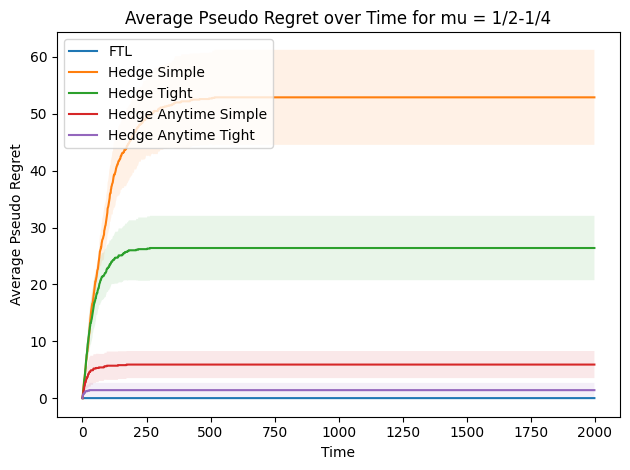

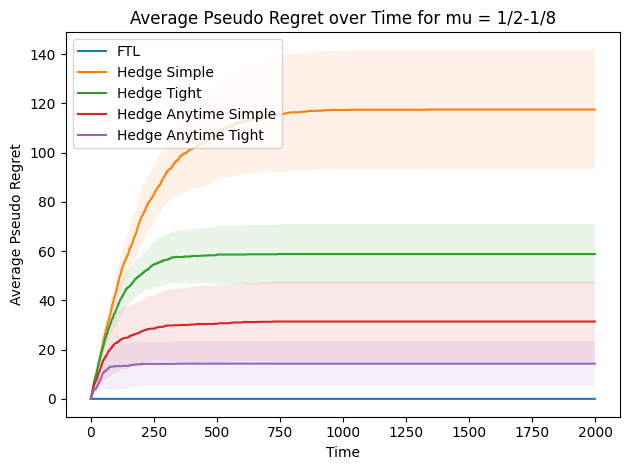

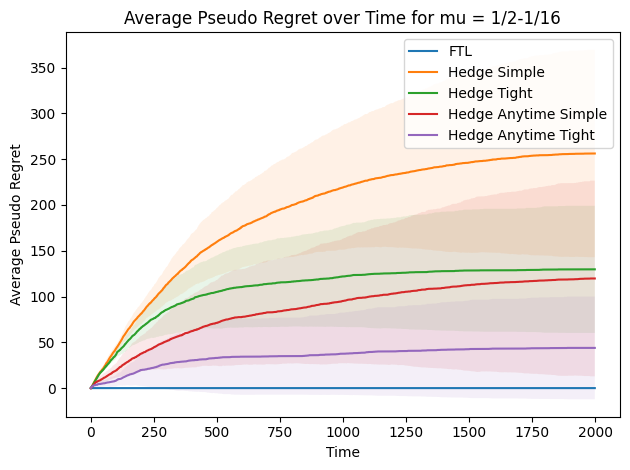

In [7]:
run_experiment(bernoulli_sequence, compute_empirical_pseudo_regret, K, T, mu_fracs, num_runs, 'bernoulli')

# Q 2


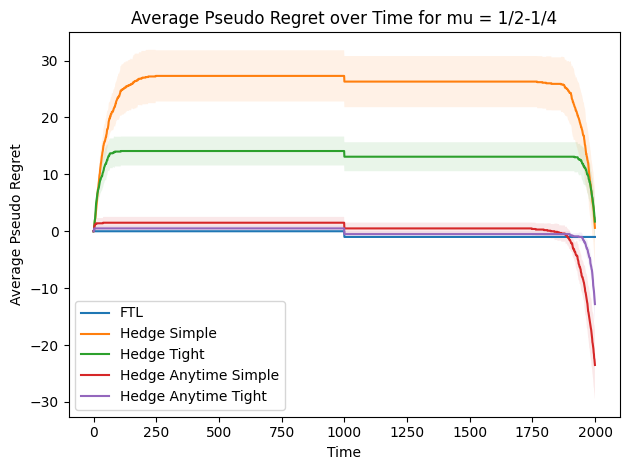

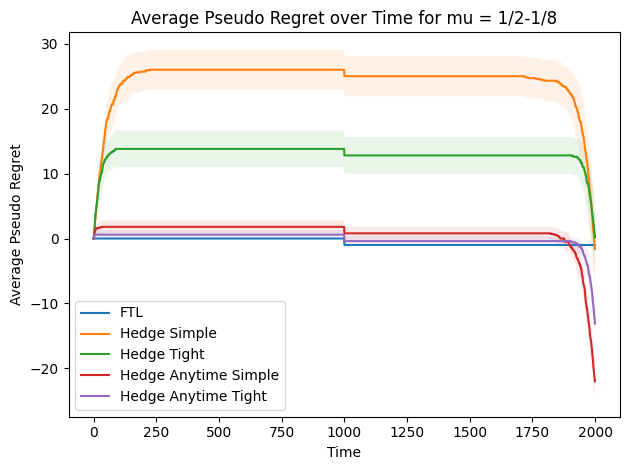

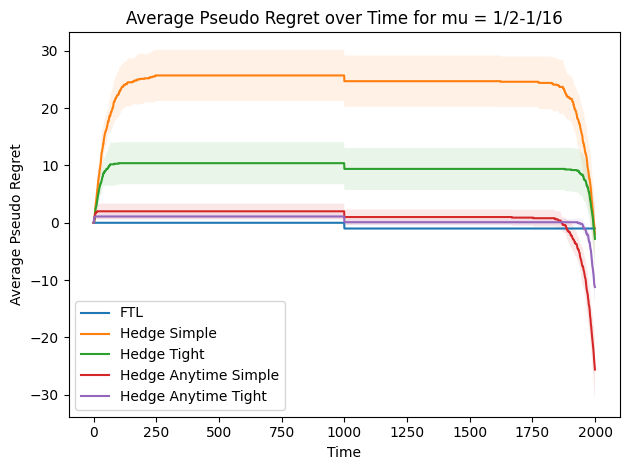

In [8]:

def compute_regret(X, predictions, T):
    regret = np.zeros(T)
    
    # Cumulative losses for predicting "0" or "1" over time
    cumulative_losses_0 = np.cumsum(1 - X)  # Loss when we could have predicted "0"
    cumulative_losses_1 = np.cumsum(X)      # Loss when we could have predicted "1"

    for t in range(1, T):
        # Calculate the loss of the algorithm up to time t (l.h. side of regret equation)
        loss_algorithm = np.sum(predictions[:t] != X[:t])
        
        # Find the best static action's loss up to time t (r.h. side of regret equation)
        best_static_loss = min(cumulative_losses_0[t], cumulative_losses_1[t])
        
        # Compute the regret at time t
        regret[t] = loss_algorithm - best_static_loss
        
    return regret

run_experiment(adversarial_sequence, compute_regret, K, T, mu_fracs, num_runs, 'adversarial')